#### Import packages and device selection

In [6]:
import os
import re
import cv2
from tqdm import tqdm
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchinfo import summary
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SIZE = 160
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print("Using device: ", device)

Using device:  cuda


## Dataset Loading and Preprocessing

In [7]:
def sort_files(folder):
    convert_func = lambda x: int(x) if x.isdigit() else x.lower()
    key_func = lambda x: [convert_func(c) for c in re.split('([0-9]+)', x)]
    return sorted(folder, key=key_func)

data_color = []
path = '../data/color'
folder = os.listdir(path)
folder = sort_files(folder)
for file in tqdm(folder):
    img = cv2.imread(path + '/' + file, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    data_color.append(img)
data_color = np.array(data_color)

data_gray = []
path = '../data/gray'
folder = os.listdir(path)
folder = sort_files(folder)
for file in tqdm(folder):
    img = cv2.imread(path + '/' + file, 1)
    img = cv2.resize(img, (SIZE, SIZE))
    data_gray.append(img)
data_gray = np.array(data_gray)



  0%|          | 0/7129 [00:00<?, ?it/s]

  0%|          | 1/7129 [00:00<23:49,  4.99it/s]

  0%|          | 13/7129 [00:00<02:21, 50.46it/s]

  0%|          | 25/7129 [00:00<01:36, 73.72it/s]

  1%|          | 38/7129 [00:00<01:17, 91.81it/s]

  1%|          | 59/7129 [00:00<00:55, 126.31it/s]

  1%|          | 79/7129 [00:00<00:47, 146.91it/s]

  2%|▏         | 113/7129 [00:00<00:34, 201.68it/s]

  2%|▏         | 152/7129 [00:00<00:27, 252.76it/s]

  3%|▎         | 205/7129 [00:01<00:20, 332.93it/s]

  4%|▍         | 278/7129 [00:01<00:15, 450.03it/s]

  5%|▍         | 325/7129 [00:01<00:15, 436.06it/s]

  5%|▌         | 370/7129 [00:01<00:15, 439.43it/s]

  6%|▌         | 419/7129 [00:01<00:15, 445.47it/s]

  7%|▋         | 493/7129 [00:01<00:12, 529.64it/s]

  8%|▊         | 547/7129 [00:01<00:14, 466.45it/s]

  8%|▊         | 604/7129 [00:01<00:13, 488.74it/s]

  9%|▉         | 662/7129 [00:01<00:12, 505.54it/s]

 10%|█         | 714/7129 [00:02<00:12, 497.57it/s]

 12%|█▏      

In [5]:
print(data_color.shape, data_gray.shape)

(7129, 160, 160, 3) (7129, 160, 160, 3)


#### Display some samples

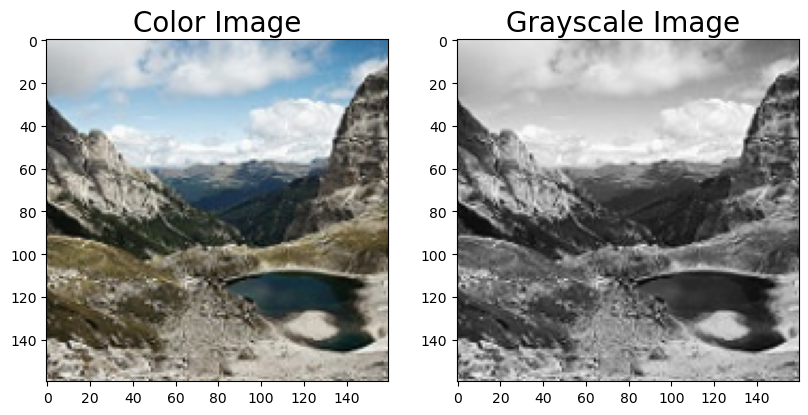

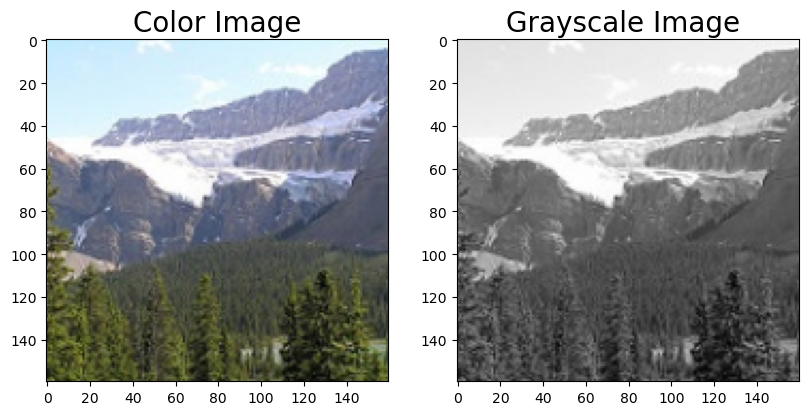

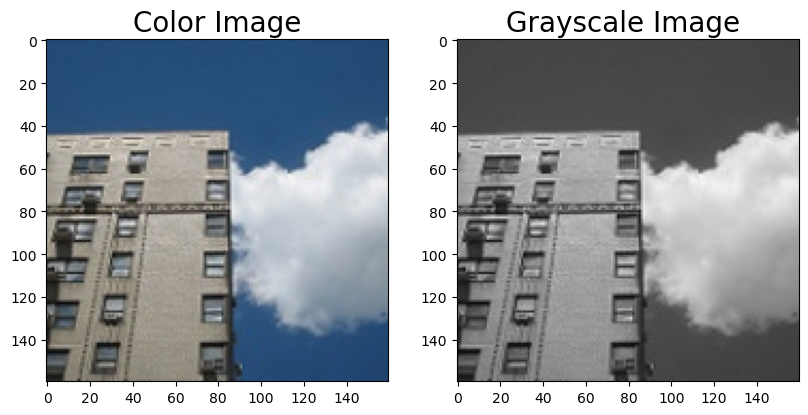

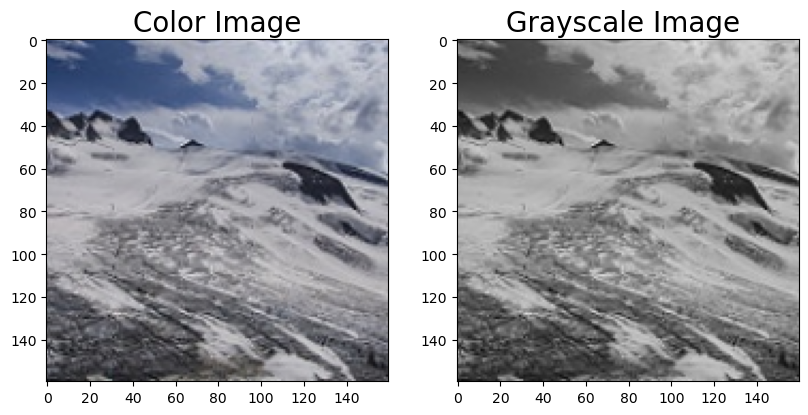

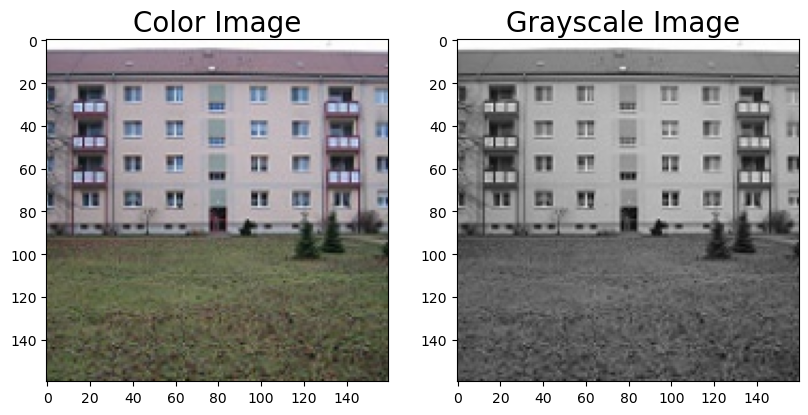

In [6]:
for _ in range(5):
    idx = np.random.randint(0, len(data_color) - 1)
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Color Image', fontsize=20)
    plt.imshow(data_color[idx])
    plt.subplot(1, 3, 2)
    plt.title('Grayscale Image ', fontsize=20)
    plt.imshow(data_gray[idx])
    plt.show()


In [10]:
color_min = np.min(data_color, axis=(0, 1, 2), keepdims=True)
color_max = np.max(data_color, axis=(0, 1, 2), keepdims=True)
gray_min = np.min(data_gray, axis=(0, 1, 2), keepdims=True)
gray_max = np.max(data_gray, axis=(0, 1, 2), keepdims=True)
data_color_scaled = (data_color - color_min) / (color_max - color_min)
data_gray_scaled = (data_gray - gray_min) / (gray_max - gray_min)
color_mean = np.mean(data_color_scaled, axis=(0, 1, 2))
color_std = np.std(data_color_scaled, axis=(0, 1, 2))
gray_mean = np.mean(data_gray_scaled, axis=(0, 1, 2))
gray_std = np.std(data_gray_scaled, axis=(0, 1, 2))

In [11]:
print(color_mean, color_std)
print(gray_mean, gray_std)

[0.4259814  0.45559374 0.44937065] [0.25829469 0.25662458 0.29237895]
[0.44589136 0.44589136 0.44589136] [0.25375797 0.25375797 0.25375797]


In [12]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_gray, data_color, gray_transform=None, color_transform=None):
        self.data_color = data_color
        self.data_gray = data_gray
        self.gray_transform = gray_transform
        self.color_transform = color_transform

    def __len__(self):
        return len(self.data_gray)

    def __getitem__(self, idx):
        gray_img = self.data_gray[idx]
        color_img = self.data_color[idx]
        if self.gray_transform:
            gray_img = self.gray_transform(gray_img)
        if self.color_transform:
            color_img = self.color_transform(color_img)
        return gray_img, color_img

In [16]:
gray_train, gray_test, color_train, color_test = (
    train_test_split(data_gray, data_color, test_size=0.2, random_state=42))

In [17]:
print(len(gray_train), len(gray_test))

5703 1426


## Training pipeline

#### Split into training and test data

In [18]:
gray_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=gray_mean, std=gray_std)
])
color_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=color_mean, std=color_std)
])
trainset = MyDataset(gray_train, color_train, gray_transform=gray_transform, color_transform=color_transform)
testset = MyDataset(gray_test, color_test, gray_transform=gray_transform, color_transform=color_transform)

#### Early stopping used to stop training if model begins to overfit

In [19]:
class EarlyStopping:
    def __init__(self, patience=15, delta=0.5, window_size=10):
        self.patience = patience
        self.counter = 0
        self.best_score = np.Inf
        self.early_stop = False
        self.delta = delta
        self.window_size = window_size
        self.val_window = []

    def __call__(self, val_loss, net):
        self.val_window.append(val_loss)
        if len(self.val_window) > self.window_size:
            self.val_window.pop(0)
        avg_val = np.mean(self.val_window)

        if avg_val == self.best_score or avg_val > self.best_score + self.delta:
            self.counter += 1
        elif avg_val < self.best_score:
            self.best_score = avg_val
            self.save_checkpoint(net)
            self.counter = 0
        if self.counter >= self.patience:
            self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), '../models/checkpoint.pth')

#### ImageGradienLoss class and fit/predict methods

$ \_comp.pow(2).sum(dim=1)$ computes $∑𝑐[Δ]^2$ directly, which is algebraically identical to $∥Δ∥_2^2$ but skips the square‐root.

In [ ]:
class ImageGradientLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(ImageGradientLoss, self).__init__()

    def forward(self, inputs, targets):
        dh_comp = inputs.diff(dim=3) - targets.diff(dim=3) # (B, C, H, W-1)
        dv_comp = inputs.diff(dim=2) - targets.diff(dim=2) # (B, C, H-1, W)
        dh_comp = dh_comp.pow(2).sum(dim=1)
        dv_comp = dv_comp.pow(2).sum(dim=1)
        return dh_comp.sum() + dv_comp.sum()

def fit(net, trainloader, optimizer, loss_fn1=nn.MSELoss(reduction='sum'), loss_fn2=ImageGradientLoss(), lamda1=0.5, lamda2=0.5):
    net.train()
    total_loss, acc, count = 0, 0, 0
    for grays, colors in tqdm(trainloader):
        grays, colors = grays.to(device), colors.to(device)
        optimizer.zero_grad()
        out = net(grays)
        loss1, loss2 = loss_fn1(out, colors), loss_fn2(out, colors)
        loss = (lamda1 * loss1 + lamda2 * loss2) / out.numel()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = torch.max(out, 1)[1]
        acc += (predicted == colors).sum().item()
        count += len(colors)
    return total_loss / count, acc / count

def predict(net, testloader, loss_fn1=nn.MSELoss(reduction='sum'), loss_fn2=ImageGradientLoss(), lamda1=0.5, lamda2=0.5):
    net.eval()
    total_loss, acc, count = 0, 0, 0
    with torch.no_grad():
        for grays, colors in tqdm(testloader):
            grays, colors = grays.to(device), colors.to(device)
            out = net(grays)
            loss1, loss2 = loss_fn1(out, colors), loss_fn2(out, colors)
            loss = (lamda1 * loss1 + lamda2 * loss2) / out.numel()
            total_loss += loss.item()
            predicted = torch.max(out, 1)[1]
            acc += (predicted == colors).sum().item()
            count += len(colors)
    return total_loss / count, acc / count